#### To replicate our work, import the following libraries

In [100]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

#### Clone python files from google text classification github repository
https://github.com/google/eng-edu/tree/master/ml/guides/text_classification

In [146]:
import build_model
import load_data
import vectorize_data
import explore_data


### our training data : https://github.com/rasbt/musicmood/blob/master/dataset/training/train_lyrics_1000.csv
### our validation data: https://github.com/rasbt/musicmood/blob/master/dataset/validation/valid_lyrics_200.csv

In [151]:
training_set = pd.read_csv('train_lyrics_1000.csv',encoding='UTF-8')
validation_set = pd.read_csv('valid_lyrics_200.csv',encoding='UTF-8')

#### Mapping 0,1 for the target labels sad, happy respectively

In [152]:
training_set['mood'] = training_set['mood'].apply(lambda x:1 if x=='happy' else 0)
validation_set['mood'] = validation_set['mood'].apply(lambda x:1 if x=='happy' else 0)

In [153]:
training_set['lyrics'].head()

0    Verse One:\n\nAlright I might\nHave had a litt...
1    Adam Ant/Marco Pirroni\nEvery girl is a someth...
2    I've just erased it's been a while, I've got a...
3    Little darling \nWhere you've been so long \nI...
4    Lead Vocal by Greg\n\nWell, these late night c...
Name: lyrics, dtype: object

In [154]:
#function to clean lyrics
def replace_special_chars(i):
    i=i.split('\n')
    i=' '.join(i)
    a = re.sub('[^A-Za-z]+',' ',str(i))
    a = a.lower()
    return a

In [155]:
#cleaning the lyrics
training_set['lyrics']= training_set['lyrics'].apply(lambda x:replace_special_chars(x))
validation_set['lyrics']=validation_set['lyrics'].apply(lambda x:replace_special_chars(x))

In [156]:
training_set['lyrics'].head()

0    verse one alright i might have had a little gl...
1    adam ant marco pirroni every girl is a somethi...
2    i ve just erased it s been a while i ve got a ...
3    little darling where you ve been so long i ve ...
4    lead vocal by greg well these late night conve...
Name: lyrics, dtype: object

In [108]:
number_of_words_per_sample = explore_data.get_num_words_per_sample(training_set['lyrics'])

In [109]:
no_of_samples = training_set.shape[0]

#### we are checking no. of words per samples to  no. of sample ratio as as criteria to create our model using n-gram approach or sequence approach. If s_w_ratio>1500, sequence approach otherwise n-gram.

In [110]:
s_w_ratio  = number_of_words_per_sample/no_of_samples
s_w_ratio

0.214

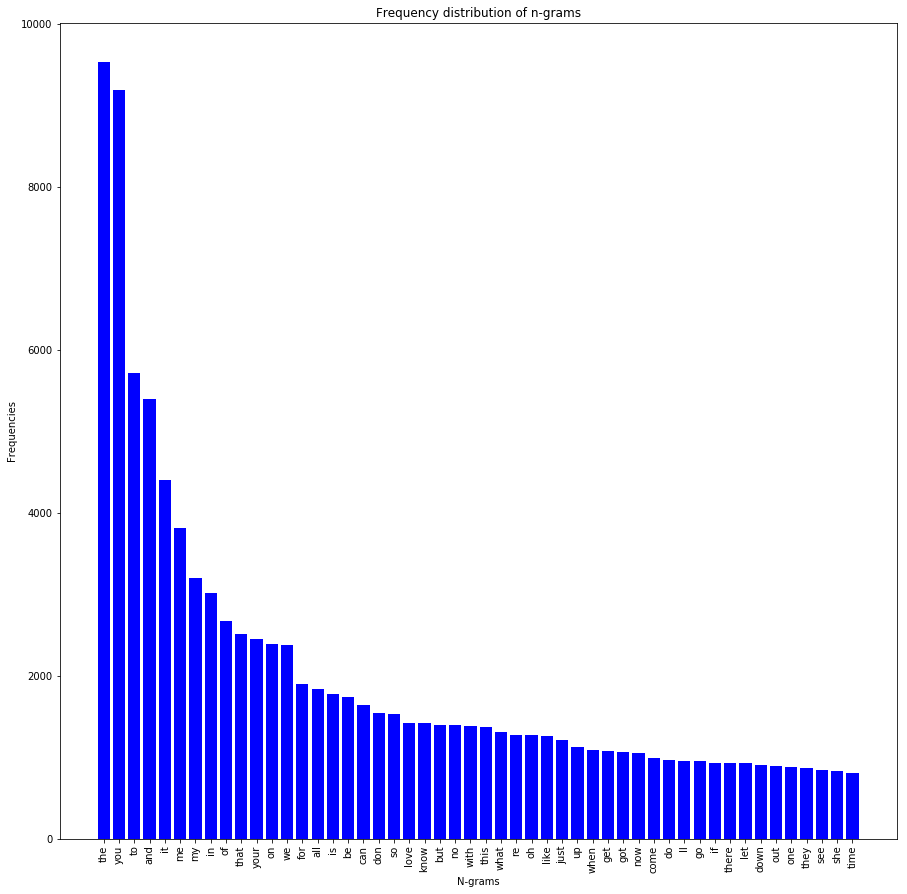

In [111]:
explore_data.plot_frequency_distribution_of_ngrams(training_set['lyrics'])

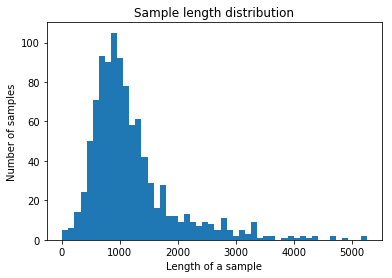

In [112]:
explore_data.plot_sample_length_distribution(training_set['lyrics'])

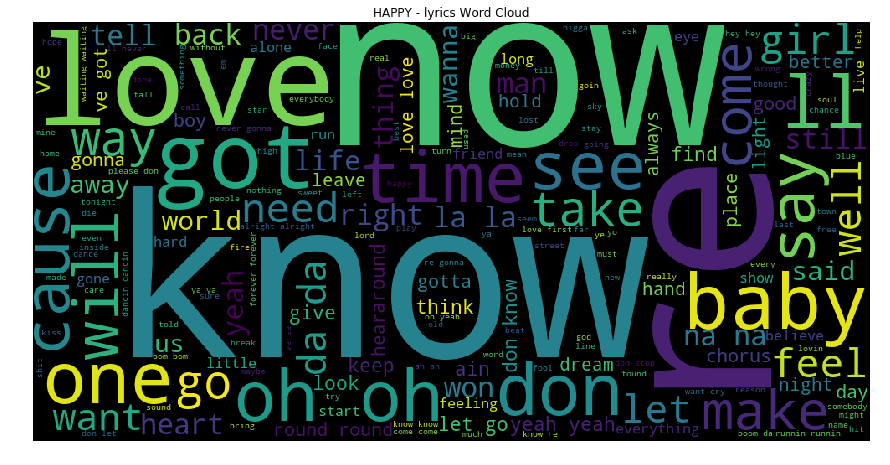

In [113]:
from wordcloud import WordCloud
str_happy = ""
happy_df = training_set.loc[training_set['mood'] == 1,:]

for happy in happy_df['lyrics'].tolist():
       str_happy = str_happy + happy
wordcloud_happy = WordCloud(width = 1000, height = 500).generate(str_happy)
plt.figure(figsize=(15,8))
plt.title('HAPPY - lyrics Word Cloud')
plt.imshow(wordcloud_happy)
plt.axis("off")
plt.savefig("happy"+".png", bbox_inches='tight')
plt.show()
plt.close()

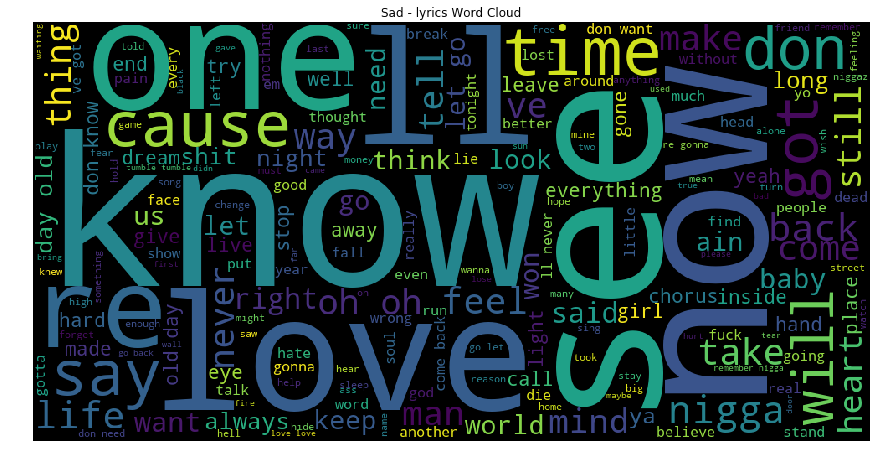

In [114]:
from wordcloud import WordCloud
str_sad = ""
sad_df = training_set.loc[training_set['mood'] == 0,:]

for sad in sad_df['lyrics'].tolist():
       str_sad = str_sad + sad
wordcloud_sad = WordCloud(width = 1000, height = 500).generate(str_sad)
plt.figure(figsize=(15,8))
plt.title('Sad - lyrics Word Cloud')
plt.imshow(wordcloud_sad)
plt.axis("off")
plt.savefig("Sad"+".png", bbox_inches='tight')
plt.show()
plt.close()

In [115]:
train_labels = training_set['mood']

In [116]:
x_train,x_val = vectorize_data.ngram_vectorize(training_set['lyrics'],train_labels,validation_set['lyrics'])

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1567: UserWarning: Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. int32 'dtype' will be converted to np.float64.
  UserWarning)


In [117]:
"""Module to train n-gram model.

Vectorizes training and validation texts into n-grams and uses that for
training a n-gram model - a simple multi-layer perceptron model. We use n-gram
model for text classification when the ratio of number of samples to number of
words per sample for the given dataset is very small (<~1500).
"""
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import argparse
import time

import tensorflow as tf
import numpy as np

import build_model
import load_data
import vectorize_data
import explore_data

FLAGS = None


def train_ngram_model(train_data,valid_data,
                      learning_rate=1e-3,
                      epochs=1000,
                      batch_size=128,
                      layers=2,
                      units=64,
                      dropout_rate=0.2):
    """Trains n-gram model on the given dataset.

    # Arguments
        data: tuples of training and test texts and labels.
        learning_rate: float, learning rate for training model.
        epochs: int, number of epochs.
        batch_size: int, number of samples per batch.
        layers: int, number of `Dense` layers in the model.
        units: int, output dimension of Dense layers in the model.
        dropout_rate: float: percentage of input to drop at Dropout layers.

    # Raises
       
       ValueError: If validation data has label values which were not seen
            in the training data.
    """
    # Get the data.
    #(train_texts, train_labels), (val_texts, val_labels) = data
    train_texts=train_data['lyrics']
    train_labels = train_data['mood']
    val_texts = valid_data['lyrics']
    val_labels= valid_data['mood']

    # Verify that validation labels are in the same range as training labels.
    num_classes = explore_data.get_num_classes(train_labels)
    unexpected_labels = [v for v in val_labels if v not in range(num_classes)]
    if len(unexpected_labels):
        raise ValueError('Unexpected label values found in the validation set:'
                         ' {unexpected_labels}. Please make sure that the '
                         'labels in the validation set are in the same range '
                         'as training labels.'.format(
                             unexpected_labels=unexpected_labels))

    # Vectorize texts.
    x_train, x_val = vectorize_data.ngram_vectorize(
        train_texts, train_labels, val_texts)

    # Create model instance.
    model = build_model.mlp_model(layers=layers,
                                  units=units,
                                  dropout_rate=dropout_rate,
                                  input_shape=x_train.shape[1:],
                                  num_classes=num_classes)

    # Compile model with learning parameters.
    if num_classes == 2:
        loss = 'binary_crossentropy'
    else:
        loss = 'sparse_categorical_crossentropy'
    optimizer = tf.keras.optimizers.Adam(lr=learning_rate)
    model.compile(optimizer=optimizer, loss=loss, metrics=['acc'])

    # Create callback for early stopping on validation loss. If the loss does
    # not decrease in two consecutive tries, stop training.
    callbacks = [tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=2)]

    # Train and validate model.
    history = model.fit(
            x_train,
            train_labels,
            epochs=epochs,
            callbacks=callbacks,
            validation_data=(x_val, val_labels),
            verbose=2,  # Logs once per epoch.
            batch_size=batch_size)

    # Print results.
    history = history.history
    print('Validation accuracy: {acc}, loss: {loss}'.format(
            acc=history['val_acc'][-1], loss=history['val_loss'][-1]))

    # Save model.
    model.save('song_mood_mlp_model.h5')
    return model,history['val_acc'][-1], history['val_loss'][-1]


if __name__ == '__main__':

    
    train_data = training_set
    valid_data = validation_set
    history=train_ngram_model(training_set,validation_set)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1567: UserWarning: Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. int32 'dtype' will be converted to np.float64.
  UserWarning)


Train on 1000 samples, validate on 200 samples
Epoch 1/1000
 - 1s - loss: 0.6903 - acc: 0.5640 - val_loss: 0.6927 - val_acc: 0.4800
Epoch 2/1000
 - 0s - loss: 0.6694 - acc: 0.5920 - val_loss: 0.6881 - val_acc: 0.4800
Epoch 3/1000
 - 0s - loss: 0.6440 - acc: 0.6670 - val_loss: 0.6800 - val_acc: 0.5150
Epoch 4/1000
 - 0s - loss: 0.6123 - acc: 0.7710 - val_loss: 0.6693 - val_acc: 0.5450
Epoch 5/1000
 - 0s - loss: 0.5775 - acc: 0.8460 - val_loss: 0.6571 - val_acc: 0.5850
Epoch 6/1000
 - 0s - loss: 0.5364 - acc: 0.9050 - val_loss: 0.6455 - val_acc: 0.6200
Epoch 7/1000
 - 0s - loss: 0.4990 - acc: 0.9360 - val_loss: 0.6331 - val_acc: 0.6400
Epoch 8/1000
 - 0s - loss: 0.4567 - acc: 0.9480 - val_loss: 0.6195 - val_acc: 0.6850
Epoch 9/1000
 - 0s - loss: 0.4212 - acc: 0.9660 - val_loss: 0.6084 - val_acc: 0.7050
Epoch 10/1000
 - 0s - loss: 0.3781 - acc: 0.9800 - val_loss: 0.5984 - val_acc: 0.7200
Epoch 11/1000
 - 0s - loss: 0.3453 - acc: 0.9780 - val_loss: 0.5893 - val_acc: 0.7300
Epoch 12/1000
 -

# Tune Model

In [145]:
from tune_ngram_model import tune_ngram_model 

In [122]:
training_set = pd.read_csv('train_lyrics_1000.csv',encoding='UTF-8')
validation_set = pd.read_csv('valid_lyrics_200.csv',encoding='UTF-8')
training_set['mood'] = training_set['mood'].apply(lambda x:1 if x=='happy' else 0)
validation_set['mood'] = validation_set['mood'].apply(lambda x:1 if x=='happy' else 0)

In [123]:
data = (training_set['lyrics'], training_set['mood']), (validation_set['lyrics'], validation_set['mood'])

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1567: UserWarning: Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. int32 'dtype' will be converted to np.float64.
  UserWarning)


Train on 1000 samples, validate on 200 samples
Epoch 1/1000
 - 1s - loss: 0.6921 - acc: 0.5420 - val_loss: 0.6921 - val_acc: 0.5450
Epoch 2/1000
 - 0s - loss: 0.6872 - acc: 0.6610 - val_loss: 0.6912 - val_acc: 0.5150
Epoch 3/1000
 - 0s - loss: 0.6830 - acc: 0.6620 - val_loss: 0.6904 - val_acc: 0.5000
Epoch 4/1000
 - 0s - loss: 0.6785 - acc: 0.6590 - val_loss: 0.6896 - val_acc: 0.4850
Epoch 5/1000
 - 0s - loss: 0.6742 - acc: 0.6630 - val_loss: 0.6888 - val_acc: 0.4850
Epoch 6/1000
 - 0s - loss: 0.6701 - acc: 0.6590 - val_loss: 0.6880 - val_acc: 0.4950
Epoch 7/1000
 - 0s - loss: 0.6661 - acc: 0.6700 - val_loss: 0.6872 - val_acc: 0.4950
Epoch 8/1000
 - 0s - loss: 0.6623 - acc: 0.6710 - val_loss: 0.6866 - val_acc: 0.4950
Epoch 9/1000
 - 0s - loss: 0.6580 - acc: 0.6600 - val_loss: 0.6860 - val_acc: 0.4950
Epoch 10/1000
 - 0s - loss: 0.6546 - acc: 0.6680 - val_loss: 0.6853 - val_acc: 0.4950
Epoch 11/1000
 - 0s - loss: 0.6512 - acc: 0.6640 - val_loss: 0.6845 - val_acc: 0.4950
Epoch 12/1000
 -

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1567: UserWarning: Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. int32 'dtype' will be converted to np.float64.
  UserWarning)


Train on 1000 samples, validate on 200 samples
Epoch 1/1000
 - 1s - loss: 0.6922 - acc: 0.5410 - val_loss: 0.6917 - val_acc: 0.5600
Epoch 2/1000
 - 0s - loss: 0.6873 - acc: 0.6530 - val_loss: 0.6908 - val_acc: 0.5250
Epoch 3/1000
 - 0s - loss: 0.6832 - acc: 0.6560 - val_loss: 0.6899 - val_acc: 0.4950
Epoch 4/1000
 - 0s - loss: 0.6788 - acc: 0.6580 - val_loss: 0.6890 - val_acc: 0.4850
Epoch 5/1000
 - 0s - loss: 0.6748 - acc: 0.6440 - val_loss: 0.6882 - val_acc: 0.4850
Epoch 6/1000
 - 0s - loss: 0.6710 - acc: 0.6370 - val_loss: 0.6874 - val_acc: 0.4850
Epoch 7/1000
 - 0s - loss: 0.6668 - acc: 0.6410 - val_loss: 0.6866 - val_acc: 0.4850
Epoch 8/1000
 - 0s - loss: 0.6633 - acc: 0.6350 - val_loss: 0.6858 - val_acc: 0.4900
Epoch 9/1000
 - 0s - loss: 0.6590 - acc: 0.6540 - val_loss: 0.6851 - val_acc: 0.4900
Epoch 10/1000
 - 0s - loss: 0.6548 - acc: 0.6510 - val_loss: 0.6844 - val_acc: 0.4900
Epoch 11/1000
 - 0s - loss: 0.6513 - acc: 0.6640 - val_loss: 0.6836 - val_acc: 0.4900
Epoch 12/1000
 -

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1567: UserWarning: Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. int32 'dtype' will be converted to np.float64.
  UserWarning)


Train on 1000 samples, validate on 200 samples
Epoch 1/1000
 - 1s - loss: 0.6925 - acc: 0.5390 - val_loss: 0.6926 - val_acc: 0.4950
Epoch 2/1000
 - 0s - loss: 0.6875 - acc: 0.6480 - val_loss: 0.6920 - val_acc: 0.4950
Epoch 3/1000
 - 0s - loss: 0.6831 - acc: 0.6450 - val_loss: 0.6912 - val_acc: 0.4950
Epoch 4/1000
 - 0s - loss: 0.6788 - acc: 0.6440 - val_loss: 0.6904 - val_acc: 0.4900
Epoch 5/1000
 - 0s - loss: 0.6748 - acc: 0.6370 - val_loss: 0.6896 - val_acc: 0.4850
Epoch 6/1000
 - 0s - loss: 0.6704 - acc: 0.6310 - val_loss: 0.6888 - val_acc: 0.4900
Epoch 7/1000
 - 0s - loss: 0.6665 - acc: 0.6410 - val_loss: 0.6880 - val_acc: 0.4900
Epoch 8/1000
 - 0s - loss: 0.6627 - acc: 0.6490 - val_loss: 0.6873 - val_acc: 0.4900
Epoch 9/1000
 - 0s - loss: 0.6588 - acc: 0.6480 - val_loss: 0.6866 - val_acc: 0.4900
Epoch 10/1000
 - 0s - loss: 0.6546 - acc: 0.6520 - val_loss: 0.6858 - val_acc: 0.4900
Epoch 11/1000
 - 0s - loss: 0.6508 - acc: 0.6720 - val_loss: 0.6850 - val_acc: 0.4900
Epoch 12/1000
 -

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1567: UserWarning: Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. int32 'dtype' will be converted to np.float64.
  UserWarning)


Train on 1000 samples, validate on 200 samples
Epoch 1/1000
 - 1s - loss: 0.6927 - acc: 0.5360 - val_loss: 0.6918 - val_acc: 0.5700
Epoch 2/1000
 - 0s - loss: 0.6879 - acc: 0.6500 - val_loss: 0.6910 - val_acc: 0.5250
Epoch 3/1000
 - 0s - loss: 0.6835 - acc: 0.6620 - val_loss: 0.6901 - val_acc: 0.5150
Epoch 4/1000
 - 0s - loss: 0.6790 - acc: 0.6690 - val_loss: 0.6893 - val_acc: 0.5000
Epoch 5/1000
 - 0s - loss: 0.6751 - acc: 0.6600 - val_loss: 0.6886 - val_acc: 0.4900
Epoch 6/1000
 - 0s - loss: 0.6711 - acc: 0.6520 - val_loss: 0.6878 - val_acc: 0.4900
Epoch 7/1000
 - 0s - loss: 0.6671 - acc: 0.6460 - val_loss: 0.6871 - val_acc: 0.4900
Epoch 8/1000
 - 0s - loss: 0.6628 - acc: 0.6530 - val_loss: 0.6863 - val_acc: 0.4850
Epoch 9/1000
 - 0s - loss: 0.6592 - acc: 0.6580 - val_loss: 0.6856 - val_acc: 0.4850
Epoch 10/1000
 - 0s - loss: 0.6551 - acc: 0.6700 - val_loss: 0.6848 - val_acc: 0.4850
Epoch 11/1000
 - 0s - loss: 0.6513 - acc: 0.6850 - val_loss: 0.6840 - val_acc: 0.4850
Epoch 12/1000
 -

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1567: UserWarning: Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. int32 'dtype' will be converted to np.float64.
  UserWarning)


Train on 1000 samples, validate on 200 samples
Epoch 1/1000
 - 1s - loss: 0.6925 - acc: 0.5450 - val_loss: 0.6927 - val_acc: 0.5150
Epoch 2/1000
 - 0s - loss: 0.6876 - acc: 0.6580 - val_loss: 0.6918 - val_acc: 0.5250
Epoch 3/1000
 - 0s - loss: 0.6831 - acc: 0.6680 - val_loss: 0.6909 - val_acc: 0.5100
Epoch 4/1000
 - 0s - loss: 0.6790 - acc: 0.6670 - val_loss: 0.6901 - val_acc: 0.5050
Epoch 5/1000
 - 0s - loss: 0.6749 - acc: 0.6560 - val_loss: 0.6893 - val_acc: 0.5000
Epoch 6/1000
 - 0s - loss: 0.6710 - acc: 0.6540 - val_loss: 0.6886 - val_acc: 0.4950
Epoch 7/1000
 - 0s - loss: 0.6668 - acc: 0.6520 - val_loss: 0.6878 - val_acc: 0.4950
Epoch 8/1000
 - 0s - loss: 0.6628 - acc: 0.6620 - val_loss: 0.6871 - val_acc: 0.4950
Epoch 9/1000
 - 0s - loss: 0.6588 - acc: 0.6530 - val_loss: 0.6862 - val_acc: 0.4950
Epoch 10/1000
 - 0s - loss: 0.6555 - acc: 0.6650 - val_loss: 0.6854 - val_acc: 0.4950
Epoch 11/1000
 - 0s - loss: 0.6515 - acc: 0.6690 - val_loss: 0.6846 - val_acc: 0.4900
Epoch 12/1000
 -

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1567: UserWarning: Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. int32 'dtype' will be converted to np.float64.
  UserWarning)


Train on 1000 samples, validate on 200 samples
Epoch 1/1000
 - 2s - loss: 0.6937 - acc: 0.4870 - val_loss: 0.6919 - val_acc: 0.5950
Epoch 2/1000
 - 0s - loss: 0.6878 - acc: 0.7680 - val_loss: 0.6905 - val_acc: 0.6300
Epoch 3/1000
 - 0s - loss: 0.6816 - acc: 0.8560 - val_loss: 0.6871 - val_acc: 0.6900
Epoch 4/1000
 - 0s - loss: 0.6742 - acc: 0.8450 - val_loss: 0.6828 - val_acc: 0.6900
Epoch 5/1000
 - 0s - loss: 0.6636 - acc: 0.8590 - val_loss: 0.6783 - val_acc: 0.7000
Epoch 6/1000
 - 0s - loss: 0.6501 - acc: 0.8950 - val_loss: 0.6743 - val_acc: 0.7100
Epoch 7/1000
 - 0s - loss: 0.6383 - acc: 0.9100 - val_loss: 0.6700 - val_acc: 0.6900
Epoch 8/1000
 - 0s - loss: 0.6266 - acc: 0.9040 - val_loss: 0.6656 - val_acc: 0.6850
Epoch 9/1000
 - 0s - loss: 0.6137 - acc: 0.9200 - val_loss: 0.6613 - val_acc: 0.6750
Epoch 10/1000
 - 0s - loss: 0.6020 - acc: 0.9230 - val_loss: 0.6573 - val_acc: 0.6800
Epoch 11/1000
 - 0s - loss: 0.5885 - acc: 0.9350 - val_loss: 0.6534 - val_acc: 0.6850
Epoch 12/1000
 -

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1567: UserWarning: Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. int32 'dtype' will be converted to np.float64.
  UserWarning)


Train on 1000 samples, validate on 200 samples
Epoch 1/1000
 - 2s - loss: 0.6917 - acc: 0.5570 - val_loss: 0.6923 - val_acc: 0.4750
Epoch 2/1000
 - 0s - loss: 0.6812 - acc: 0.6090 - val_loss: 0.6899 - val_acc: 0.4750
Epoch 3/1000
 - 0s - loss: 0.6679 - acc: 0.6520 - val_loss: 0.6860 - val_acc: 0.4850
Epoch 4/1000
 - 0s - loss: 0.6528 - acc: 0.7040 - val_loss: 0.6820 - val_acc: 0.5050
Epoch 5/1000
 - 0s - loss: 0.6352 - acc: 0.7470 - val_loss: 0.6773 - val_acc: 0.5400
Epoch 6/1000
 - 0s - loss: 0.6169 - acc: 0.7920 - val_loss: 0.6717 - val_acc: 0.5700
Epoch 7/1000
 - 0s - loss: 0.5970 - acc: 0.8300 - val_loss: 0.6665 - val_acc: 0.5800
Epoch 8/1000
 - 0s - loss: 0.5776 - acc: 0.8740 - val_loss: 0.6606 - val_acc: 0.5800
Epoch 9/1000
 - 0s - loss: 0.5592 - acc: 0.8840 - val_loss: 0.6550 - val_acc: 0.5950
Epoch 10/1000
 - 0s - loss: 0.5377 - acc: 0.9210 - val_loss: 0.6491 - val_acc: 0.6100
Epoch 11/1000
 - 0s - loss: 0.5195 - acc: 0.9280 - val_loss: 0.6437 - val_acc: 0.5950
Epoch 12/1000
 -

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1567: UserWarning: Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. int32 'dtype' will be converted to np.float64.
  UserWarning)


Train on 1000 samples, validate on 200 samples
Epoch 1/1000
 - 2s - loss: 0.6932 - acc: 0.5020 - val_loss: 0.6919 - val_acc: 0.5250
Epoch 2/1000
 - 0s - loss: 0.6826 - acc: 0.7490 - val_loss: 0.6892 - val_acc: 0.5350
Epoch 3/1000
 - 0s - loss: 0.6694 - acc: 0.8300 - val_loss: 0.6833 - val_acc: 0.6400
Epoch 4/1000
 - 0s - loss: 0.6532 - acc: 0.9130 - val_loss: 0.6751 - val_acc: 0.7050
Epoch 5/1000
 - 0s - loss: 0.6310 - acc: 0.9500 - val_loss: 0.6670 - val_acc: 0.7600
Epoch 6/1000
 - 0s - loss: 0.6067 - acc: 0.9600 - val_loss: 0.6587 - val_acc: 0.7400
Epoch 7/1000
 - 0s - loss: 0.5811 - acc: 0.9570 - val_loss: 0.6492 - val_acc: 0.7550
Epoch 8/1000
 - 0s - loss: 0.5553 - acc: 0.9610 - val_loss: 0.6404 - val_acc: 0.7450
Epoch 9/1000
 - 0s - loss: 0.5281 - acc: 0.9730 - val_loss: 0.6323 - val_acc: 0.7350
Epoch 10/1000
 - 0s - loss: 0.4979 - acc: 0.9780 - val_loss: 0.6236 - val_acc: 0.7300
Epoch 11/1000
 - 0s - loss: 0.4715 - acc: 0.9760 - val_loss: 0.6152 - val_acc: 0.7250
Epoch 12/1000
 -

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1567: UserWarning: Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. int32 'dtype' will be converted to np.float64.
  UserWarning)


Train on 1000 samples, validate on 200 samples
Epoch 1/1000
 - 2s - loss: 0.6901 - acc: 0.5520 - val_loss: 0.6899 - val_acc: 0.4800
Epoch 2/1000
 - 0s - loss: 0.6698 - acc: 0.5860 - val_loss: 0.6855 - val_acc: 0.4700
Epoch 3/1000
 - 0s - loss: 0.6438 - acc: 0.6330 - val_loss: 0.6784 - val_acc: 0.4900
Epoch 4/1000
 - 0s - loss: 0.6119 - acc: 0.7190 - val_loss: 0.6681 - val_acc: 0.5550
Epoch 5/1000
 - 0s - loss: 0.5761 - acc: 0.7940 - val_loss: 0.6579 - val_acc: 0.5850
Epoch 6/1000
 - 0s - loss: 0.5377 - acc: 0.8630 - val_loss: 0.6467 - val_acc: 0.5950
Epoch 7/1000
 - 0s - loss: 0.4970 - acc: 0.9180 - val_loss: 0.6339 - val_acc: 0.6350
Epoch 8/1000
 - 0s - loss: 0.4575 - acc: 0.9490 - val_loss: 0.6211 - val_acc: 0.6600
Epoch 9/1000
 - 0s - loss: 0.4198 - acc: 0.9600 - val_loss: 0.6137 - val_acc: 0.6500
Epoch 10/1000
 - 0s - loss: 0.3824 - acc: 0.9720 - val_loss: 0.6048 - val_acc: 0.6800
Epoch 11/1000
 - 0s - loss: 0.3480 - acc: 0.9710 - val_loss: 0.5927 - val_acc: 0.6900
Epoch 12/1000
 -

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1567: UserWarning: Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. int32 'dtype' will be converted to np.float64.
  UserWarning)


Train on 1000 samples, validate on 200 samples
Epoch 1/1000
 - 2s - loss: 0.6892 - acc: 0.5800 - val_loss: 0.6897 - val_acc: 0.4700
Epoch 2/1000
 - 0s - loss: 0.6604 - acc: 0.6170 - val_loss: 0.6835 - val_acc: 0.4850
Epoch 3/1000
 - 0s - loss: 0.6239 - acc: 0.6740 - val_loss: 0.6723 - val_acc: 0.5350
Epoch 4/1000
 - 0s - loss: 0.5754 - acc: 0.8190 - val_loss: 0.6537 - val_acc: 0.5800
Epoch 5/1000
 - 0s - loss: 0.5247 - acc: 0.9040 - val_loss: 0.6362 - val_acc: 0.6200
Epoch 6/1000
 - 0s - loss: 0.4724 - acc: 0.9340 - val_loss: 0.6190 - val_acc: 0.6600
Epoch 7/1000
 - 0s - loss: 0.4154 - acc: 0.9560 - val_loss: 0.6045 - val_acc: 0.6900
Epoch 8/1000
 - 0s - loss: 0.3625 - acc: 0.9780 - val_loss: 0.5916 - val_acc: 0.7200
Epoch 9/1000
 - 0s - loss: 0.3150 - acc: 0.9850 - val_loss: 0.5775 - val_acc: 0.7250
Epoch 10/1000
 - 0s - loss: 0.2701 - acc: 0.9830 - val_loss: 0.5702 - val_acc: 0.7100
Epoch 11/1000
 - 0s - loss: 0.2349 - acc: 0.9910 - val_loss: 0.5634 - val_acc: 0.7100
Epoch 12/1000
 -

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1567: UserWarning: Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. int32 'dtype' will be converted to np.float64.
  UserWarning)


Train on 1000 samples, validate on 200 samples
Epoch 1/1000
 - 2s - loss: 0.6928 - acc: 0.5330 - val_loss: 0.6930 - val_acc: 0.4750
Epoch 2/1000
 - 0s - loss: 0.6911 - acc: 0.5690 - val_loss: 0.6928 - val_acc: 0.4750
Epoch 3/1000
 - 0s - loss: 0.6883 - acc: 0.5720 - val_loss: 0.6921 - val_acc: 0.4750
Epoch 4/1000
 - 0s - loss: 0.6843 - acc: 0.5750 - val_loss: 0.6912 - val_acc: 0.4750
Epoch 5/1000
 - 0s - loss: 0.6784 - acc: 0.6040 - val_loss: 0.6901 - val_acc: 0.4750
Epoch 6/1000
 - 0s - loss: 0.6727 - acc: 0.6150 - val_loss: 0.6884 - val_acc: 0.4750
Epoch 7/1000
 - 0s - loss: 0.6654 - acc: 0.6420 - val_loss: 0.6861 - val_acc: 0.4800
Epoch 8/1000
 - 0s - loss: 0.6534 - acc: 0.7050 - val_loss: 0.6828 - val_acc: 0.5000
Epoch 9/1000
 - 0s - loss: 0.6448 - acc: 0.7460 - val_loss: 0.6793 - val_acc: 0.5200
Epoch 10/1000
 - 0s - loss: 0.6312 - acc: 0.7890 - val_loss: 0.6749 - val_acc: 0.5500
Epoch 11/1000
 - 0s - loss: 0.6186 - acc: 0.8110 - val_loss: 0.6695 - val_acc: 0.5850
Epoch 12/1000
 -

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1567: UserWarning: Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. int32 'dtype' will be converted to np.float64.
  UserWarning)


Train on 1000 samples, validate on 200 samples
Epoch 1/1000
 - 3s - loss: 0.6921 - acc: 0.5560 - val_loss: 0.6936 - val_acc: 0.4750
Epoch 2/1000
 - 0s - loss: 0.6883 - acc: 0.5630 - val_loss: 0.6931 - val_acc: 0.4750
Epoch 3/1000
 - 0s - loss: 0.6822 - acc: 0.5710 - val_loss: 0.6916 - val_acc: 0.4750
Epoch 4/1000
 - 0s - loss: 0.6745 - acc: 0.5860 - val_loss: 0.6893 - val_acc: 0.4750
Epoch 5/1000
 - 0s - loss: 0.6633 - acc: 0.6280 - val_loss: 0.6852 - val_acc: 0.4900
Epoch 6/1000
 - 0s - loss: 0.6475 - acc: 0.6970 - val_loss: 0.6781 - val_acc: 0.5250
Epoch 7/1000
 - 0s - loss: 0.6252 - acc: 0.7780 - val_loss: 0.6702 - val_acc: 0.5700
Epoch 8/1000
 - 0s - loss: 0.5955 - acc: 0.8440 - val_loss: 0.6602 - val_acc: 0.5950
Epoch 9/1000
 - 0s - loss: 0.5681 - acc: 0.8760 - val_loss: 0.6500 - val_acc: 0.6350
Epoch 10/1000
 - 0s - loss: 0.5277 - acc: 0.9180 - val_loss: 0.6387 - val_acc: 0.6500
Epoch 11/1000
 - 0s - loss: 0.4949 - acc: 0.9390 - val_loss: 0.6261 - val_acc: 0.6750
Epoch 12/1000
 -

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1567: UserWarning: Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. int32 'dtype' will be converted to np.float64.
  UserWarning)


Train on 1000 samples, validate on 200 samples
Epoch 1/1000
 - 3s - loss: 0.6920 - acc: 0.5430 - val_loss: 0.6929 - val_acc: 0.4800
Epoch 2/1000
 - 0s - loss: 0.6835 - acc: 0.5700 - val_loss: 0.6921 - val_acc: 0.4750
Epoch 3/1000
 - 0s - loss: 0.6688 - acc: 0.5730 - val_loss: 0.6872 - val_acc: 0.4750
Epoch 4/1000
 - 0s - loss: 0.6460 - acc: 0.6690 - val_loss: 0.6788 - val_acc: 0.4950
Epoch 5/1000
 - 0s - loss: 0.6159 - acc: 0.7630 - val_loss: 0.6694 - val_acc: 0.5500
Epoch 6/1000
 - 0s - loss: 0.5717 - acc: 0.8610 - val_loss: 0.6545 - val_acc: 0.5900
Epoch 7/1000
 - 0s - loss: 0.5227 - acc: 0.9090 - val_loss: 0.6347 - val_acc: 0.6250
Epoch 8/1000
 - 0s - loss: 0.4576 - acc: 0.9420 - val_loss: 0.6168 - val_acc: 0.6500
Epoch 9/1000
 - 0s - loss: 0.3917 - acc: 0.9700 - val_loss: 0.5987 - val_acc: 0.6950
Epoch 10/1000
 - 0s - loss: 0.3213 - acc: 0.9840 - val_loss: 0.5767 - val_acc: 0.7150
Epoch 11/1000
 - 0s - loss: 0.2638 - acc: 0.9870 - val_loss: 0.5693 - val_acc: 0.6950
Epoch 12/1000
 -

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1567: UserWarning: Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. int32 'dtype' will be converted to np.float64.
  UserWarning)


Train on 1000 samples, validate on 200 samples
Epoch 1/1000
 - 2s - loss: 0.6912 - acc: 0.5420 - val_loss: 0.6942 - val_acc: 0.4750
Epoch 2/1000
 - 0s - loss: 0.6772 - acc: 0.5540 - val_loss: 0.6937 - val_acc: 0.4750
Epoch 3/1000
 - 0s - loss: 0.6506 - acc: 0.5570 - val_loss: 0.6884 - val_acc: 0.4750
Epoch 4/1000
 - 0s - loss: 0.6080 - acc: 0.6010 - val_loss: 0.6740 - val_acc: 0.4950
Epoch 5/1000
 - 0s - loss: 0.5418 - acc: 0.7520 - val_loss: 0.6543 - val_acc: 0.5550
Epoch 6/1000
 - 0s - loss: 0.4580 - acc: 0.8660 - val_loss: 0.6351 - val_acc: 0.6100
Epoch 7/1000
 - 0s - loss: 0.3647 - acc: 0.9410 - val_loss: 0.6079 - val_acc: 0.6300
Epoch 8/1000
 - 0s - loss: 0.2745 - acc: 0.9750 - val_loss: 0.5922 - val_acc: 0.6700
Epoch 9/1000
 - 0s - loss: 0.1949 - acc: 0.9910 - val_loss: 0.5742 - val_acc: 0.7000
Epoch 10/1000
 - 0s - loss: 0.1403 - acc: 0.9950 - val_loss: 0.5791 - val_acc: 0.7150
Epoch 11/1000
 - 0s - loss: 0.0934 - acc: 0.9960 - val_loss: 0.6022 - val_acc: 0.6950
Validation accur

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1567: UserWarning: Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. int32 'dtype' will be converted to np.float64.
  UserWarning)


Train on 1000 samples, validate on 200 samples
Epoch 1/1000
 - 2s - loss: 0.6905 - acc: 0.5430 - val_loss: 0.6938 - val_acc: 0.4750
Epoch 2/1000
 - 0s - loss: 0.6707 - acc: 0.5540 - val_loss: 0.6908 - val_acc: 0.4750
Epoch 3/1000
 - 0s - loss: 0.6304 - acc: 0.5690 - val_loss: 0.6767 - val_acc: 0.4800
Epoch 4/1000
 - 0s - loss: 0.5513 - acc: 0.7530 - val_loss: 0.6406 - val_acc: 0.5900
Epoch 5/1000
 - 0s - loss: 0.4266 - acc: 0.9020 - val_loss: 0.6006 - val_acc: 0.6600
Epoch 6/1000
 - 0s - loss: 0.2831 - acc: 0.9800 - val_loss: 0.5692 - val_acc: 0.6950
Epoch 7/1000
 - 0s - loss: 0.1566 - acc: 0.9890 - val_loss: 0.5729 - val_acc: 0.7400
Epoch 8/1000
 - 0s - loss: 0.0829 - acc: 0.9930 - val_loss: 0.5852 - val_acc: 0.7450
Validation accuracy: 0.7450000047683716, loss: 0.585205385684967
Accuracy: 0.7450000047683716, Parameters: (layers=3, units=128)


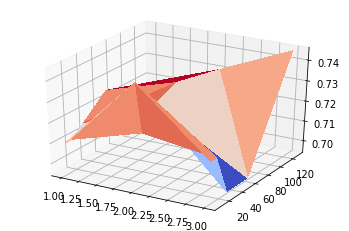

In [124]:
tune_ngram_model(data)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1567: UserWarning: Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. int32 'dtype' will be converted to np.float64.
  UserWarning)


Train on 1000 samples, validate on 200 samples
Epoch 1/1000
 - 2s - loss: 0.6929 - acc: 0.5250 - val_loss: 0.6908 - val_acc: 0.5800
Epoch 2/1000
 - 0s - loss: 0.6875 - acc: 0.6680 - val_loss: 0.6899 - val_acc: 0.5350
Epoch 3/1000
 - 0s - loss: 0.6834 - acc: 0.6810 - val_loss: 0.6890 - val_acc: 0.5250
Epoch 4/1000
 - 0s - loss: 0.6788 - acc: 0.6830 - val_loss: 0.6882 - val_acc: 0.5000
Epoch 5/1000
 - 0s - loss: 0.6748 - acc: 0.6720 - val_loss: 0.6873 - val_acc: 0.5000
Epoch 6/1000
 - 0s - loss: 0.6706 - acc: 0.6650 - val_loss: 0.6865 - val_acc: 0.4900
Epoch 7/1000
 - 0s - loss: 0.6667 - acc: 0.6580 - val_loss: 0.6857 - val_acc: 0.4850
Epoch 8/1000
 - 0s - loss: 0.6629 - acc: 0.6620 - val_loss: 0.6849 - val_acc: 0.4850
Epoch 9/1000
 - 0s - loss: 0.6588 - acc: 0.6760 - val_loss: 0.6842 - val_acc: 0.4850
Epoch 10/1000
 - 0s - loss: 0.6549 - acc: 0.6730 - val_loss: 0.6835 - val_acc: 0.4850
Epoch 11/1000
 - 0s - loss: 0.6508 - acc: 0.6790 - val_loss: 0.6827 - val_acc: 0.4800
Epoch 12/1000
 -

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1567: UserWarning: Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. int32 'dtype' will be converted to np.float64.
  UserWarning)


Train on 1000 samples, validate on 200 samples
Epoch 1/1000
 - 2s - loss: 0.6924 - acc: 0.5320 - val_loss: 0.6927 - val_acc: 0.5100
Epoch 2/1000
 - 0s - loss: 0.6873 - acc: 0.6570 - val_loss: 0.6918 - val_acc: 0.5300
Epoch 3/1000
 - 0s - loss: 0.6828 - acc: 0.6600 - val_loss: 0.6910 - val_acc: 0.5000
Epoch 4/1000
 - 0s - loss: 0.6789 - acc: 0.6470 - val_loss: 0.6902 - val_acc: 0.4900
Epoch 5/1000
 - 0s - loss: 0.6744 - acc: 0.6520 - val_loss: 0.6894 - val_acc: 0.4900
Epoch 6/1000
 - 0s - loss: 0.6703 - acc: 0.6440 - val_loss: 0.6886 - val_acc: 0.4900
Epoch 7/1000
 - 0s - loss: 0.6665 - acc: 0.6490 - val_loss: 0.6879 - val_acc: 0.4900
Epoch 8/1000
 - 0s - loss: 0.6627 - acc: 0.6460 - val_loss: 0.6872 - val_acc: 0.4900
Epoch 9/1000
 - 0s - loss: 0.6586 - acc: 0.6490 - val_loss: 0.6865 - val_acc: 0.4950
Epoch 10/1000
 - 0s - loss: 0.6551 - acc: 0.6560 - val_loss: 0.6857 - val_acc: 0.4950
Epoch 11/1000
 - 0s - loss: 0.6511 - acc: 0.6680 - val_loss: 0.6851 - val_acc: 0.4950
Epoch 12/1000
 -

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1567: UserWarning: Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. int32 'dtype' will be converted to np.float64.
  UserWarning)


Train on 1000 samples, validate on 200 samples
Epoch 1/1000
 - 2s - loss: 0.6921 - acc: 0.5560 - val_loss: 0.6918 - val_acc: 0.5650
Epoch 2/1000
 - 0s - loss: 0.6873 - acc: 0.6930 - val_loss: 0.6910 - val_acc: 0.5450
Epoch 3/1000
 - 0s - loss: 0.6829 - acc: 0.7090 - val_loss: 0.6902 - val_acc: 0.5350
Epoch 4/1000
 - 0s - loss: 0.6786 - acc: 0.6930 - val_loss: 0.6894 - val_acc: 0.5100
Epoch 5/1000
 - 0s - loss: 0.6746 - acc: 0.6810 - val_loss: 0.6886 - val_acc: 0.5050
Epoch 6/1000
 - 0s - loss: 0.6705 - acc: 0.6640 - val_loss: 0.6879 - val_acc: 0.5050
Epoch 7/1000
 - 0s - loss: 0.6665 - acc: 0.6800 - val_loss: 0.6871 - val_acc: 0.5050
Epoch 8/1000
 - 0s - loss: 0.6625 - acc: 0.6770 - val_loss: 0.6863 - val_acc: 0.5050
Epoch 9/1000
 - 0s - loss: 0.6585 - acc: 0.6810 - val_loss: 0.6855 - val_acc: 0.5050
Epoch 10/1000
 - 0s - loss: 0.6548 - acc: 0.6850 - val_loss: 0.6848 - val_acc: 0.5050
Epoch 11/1000
 - 0s - loss: 0.6512 - acc: 0.6860 - val_loss: 0.6840 - val_acc: 0.5100
Epoch 12/1000
 -

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1567: UserWarning: Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. int32 'dtype' will be converted to np.float64.
  UserWarning)


Train on 1000 samples, validate on 200 samples
Epoch 1/1000
 - 2s - loss: 0.6931 - acc: 0.4960 - val_loss: 0.6914 - val_acc: 0.5900
Epoch 2/1000
 - 0s - loss: 0.6880 - acc: 0.6990 - val_loss: 0.6906 - val_acc: 0.5900
Epoch 3/1000
 - 0s - loss: 0.6838 - acc: 0.6960 - val_loss: 0.6897 - val_acc: 0.5350
Epoch 4/1000
 - 0s - loss: 0.6797 - acc: 0.6910 - val_loss: 0.6889 - val_acc: 0.5150
Epoch 5/1000
 - 0s - loss: 0.6754 - acc: 0.6800 - val_loss: 0.6880 - val_acc: 0.5150
Epoch 6/1000
 - 0s - loss: 0.6714 - acc: 0.6750 - val_loss: 0.6871 - val_acc: 0.5100
Epoch 7/1000
 - 0s - loss: 0.6675 - acc: 0.6780 - val_loss: 0.6864 - val_acc: 0.5150
Epoch 8/1000
 - 0s - loss: 0.6633 - acc: 0.6810 - val_loss: 0.6857 - val_acc: 0.5050
Epoch 9/1000
 - 0s - loss: 0.6591 - acc: 0.6820 - val_loss: 0.6849 - val_acc: 0.5050
Epoch 10/1000
 - 0s - loss: 0.6557 - acc: 0.6860 - val_loss: 0.6842 - val_acc: 0.5050
Epoch 11/1000
 - 0s - loss: 0.6520 - acc: 0.6850 - val_loss: 0.6835 - val_acc: 0.5050
Epoch 12/1000
 -

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1567: UserWarning: Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. int32 'dtype' will be converted to np.float64.
  UserWarning)


Train on 1000 samples, validate on 200 samples
Epoch 1/1000
 - 2s - loss: 0.6926 - acc: 0.5270 - val_loss: 0.6918 - val_acc: 0.6050
Epoch 2/1000
 - 0s - loss: 0.6876 - acc: 0.6570 - val_loss: 0.6909 - val_acc: 0.5350
Epoch 3/1000
 - 0s - loss: 0.6833 - acc: 0.6830 - val_loss: 0.6902 - val_acc: 0.4950
Epoch 4/1000
 - 0s - loss: 0.6788 - acc: 0.6650 - val_loss: 0.6893 - val_acc: 0.4800
Epoch 5/1000
 - 0s - loss: 0.6749 - acc: 0.6540 - val_loss: 0.6885 - val_acc: 0.4850
Epoch 6/1000
 - 0s - loss: 0.6707 - acc: 0.6480 - val_loss: 0.6877 - val_acc: 0.4900
Epoch 7/1000
 - 0s - loss: 0.6669 - acc: 0.6580 - val_loss: 0.6869 - val_acc: 0.4900
Epoch 8/1000
 - 0s - loss: 0.6628 - acc: 0.6670 - val_loss: 0.6862 - val_acc: 0.4900
Epoch 9/1000
 - 0s - loss: 0.6589 - acc: 0.6650 - val_loss: 0.6855 - val_acc: 0.4900
Epoch 10/1000
 - 0s - loss: 0.6549 - acc: 0.6600 - val_loss: 0.6847 - val_acc: 0.4900
Epoch 11/1000
 - 0s - loss: 0.6515 - acc: 0.6840 - val_loss: 0.6839 - val_acc: 0.4950
Epoch 12/1000
 -

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1567: UserWarning: Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. int32 'dtype' will be converted to np.float64.
  UserWarning)


Train on 1000 samples, validate on 200 samples
Epoch 1/1000
 - 2s - loss: 0.6925 - acc: 0.5240 - val_loss: 0.6919 - val_acc: 0.5000
Epoch 2/1000
 - 0s - loss: 0.6865 - acc: 0.6230 - val_loss: 0.6903 - val_acc: 0.4950
Epoch 3/1000
 - 0s - loss: 0.6789 - acc: 0.6390 - val_loss: 0.6881 - val_acc: 0.4950
Epoch 4/1000
 - 0s - loss: 0.6691 - acc: 0.6800 - val_loss: 0.6849 - val_acc: 0.4950
Epoch 5/1000
 - 0s - loss: 0.6586 - acc: 0.7540 - val_loss: 0.6813 - val_acc: 0.5250
Epoch 6/1000
 - 0s - loss: 0.6465 - acc: 0.8040 - val_loss: 0.6780 - val_acc: 0.5300
Epoch 7/1000
 - 0s - loss: 0.6340 - acc: 0.8140 - val_loss: 0.6746 - val_acc: 0.5550
Epoch 8/1000
 - 0s - loss: 0.6217 - acc: 0.8540 - val_loss: 0.6708 - val_acc: 0.5800
Epoch 9/1000
 - 0s - loss: 0.6087 - acc: 0.8700 - val_loss: 0.6669 - val_acc: 0.6150
Epoch 10/1000
 - 0s - loss: 0.5955 - acc: 0.8890 - val_loss: 0.6631 - val_acc: 0.6200
Epoch 11/1000
 - 0s - loss: 0.5816 - acc: 0.8980 - val_loss: 0.6591 - val_acc: 0.6250
Epoch 12/1000
 -

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1567: UserWarning: Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. int32 'dtype' will be converted to np.float64.
  UserWarning)


Train on 1000 samples, validate on 200 samples
Epoch 1/1000
 - 3s - loss: 0.6920 - acc: 0.5470 - val_loss: 0.6914 - val_acc: 0.5000
Epoch 2/1000
 - 0s - loss: 0.6822 - acc: 0.6500 - val_loss: 0.6889 - val_acc: 0.5000
Epoch 3/1000
 - 0s - loss: 0.6708 - acc: 0.7140 - val_loss: 0.6843 - val_acc: 0.5250
Epoch 4/1000
 - 0s - loss: 0.6552 - acc: 0.8060 - val_loss: 0.6790 - val_acc: 0.5650
Epoch 5/1000
 - 0s - loss: 0.6393 - acc: 0.8590 - val_loss: 0.6730 - val_acc: 0.6200
Epoch 6/1000
 - 0s - loss: 0.6204 - acc: 0.8910 - val_loss: 0.6669 - val_acc: 0.6650
Epoch 7/1000
 - 0s - loss: 0.6015 - acc: 0.9180 - val_loss: 0.6612 - val_acc: 0.6600
Epoch 8/1000
 - 0s - loss: 0.5825 - acc: 0.9330 - val_loss: 0.6556 - val_acc: 0.6700
Epoch 9/1000
 - 0s - loss: 0.5615 - acc: 0.9380 - val_loss: 0.6491 - val_acc: 0.6900
Epoch 10/1000
 - 0s - loss: 0.5424 - acc: 0.9620 - val_loss: 0.6429 - val_acc: 0.7100
Epoch 11/1000
 - 0s - loss: 0.5214 - acc: 0.9560 - val_loss: 0.6363 - val_acc: 0.7100
Epoch 12/1000
 -

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1567: UserWarning: Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. int32 'dtype' will be converted to np.float64.
  UserWarning)


Train on 1000 samples, validate on 200 samples
Epoch 1/1000
 - 2s - loss: 0.6919 - acc: 0.5420 - val_loss: 0.6911 - val_acc: 0.5000
Epoch 2/1000
 - 0s - loss: 0.6797 - acc: 0.6290 - val_loss: 0.6881 - val_acc: 0.4850
Epoch 3/1000
 - 0s - loss: 0.6639 - acc: 0.6770 - val_loss: 0.6829 - val_acc: 0.5200
Epoch 4/1000
 - 0s - loss: 0.6446 - acc: 0.7420 - val_loss: 0.6758 - val_acc: 0.5700
Epoch 5/1000
 - 0s - loss: 0.6220 - acc: 0.8330 - val_loss: 0.6686 - val_acc: 0.5950
Epoch 6/1000
 - 0s - loss: 0.5953 - acc: 0.8650 - val_loss: 0.6609 - val_acc: 0.6100
Epoch 7/1000
 - 0s - loss: 0.5679 - acc: 0.9090 - val_loss: 0.6523 - val_acc: 0.6200
Epoch 8/1000
 - 0s - loss: 0.5391 - acc: 0.9380 - val_loss: 0.6434 - val_acc: 0.6450
Epoch 9/1000
 - 0s - loss: 0.5123 - acc: 0.9510 - val_loss: 0.6358 - val_acc: 0.6500
Epoch 10/1000
 - 0s - loss: 0.4844 - acc: 0.9460 - val_loss: 0.6270 - val_acc: 0.6750
Epoch 11/1000
 - 0s - loss: 0.4549 - acc: 0.9640 - val_loss: 0.6187 - val_acc: 0.6850
Epoch 12/1000
 -

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1567: UserWarning: Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. int32 'dtype' will be converted to np.float64.
  UserWarning)


Train on 1000 samples, validate on 200 samples
Epoch 1/1000
 - 2s - loss: 0.6903 - acc: 0.5500 - val_loss: 0.6905 - val_acc: 0.4750
Epoch 2/1000
 - 0s - loss: 0.6704 - acc: 0.5820 - val_loss: 0.6863 - val_acc: 0.4750
Epoch 3/1000
 - 0s - loss: 0.6457 - acc: 0.6240 - val_loss: 0.6790 - val_acc: 0.5000
Epoch 4/1000
 - 0s - loss: 0.6155 - acc: 0.7230 - val_loss: 0.6691 - val_acc: 0.5650
Epoch 5/1000
 - 0s - loss: 0.5810 - acc: 0.8280 - val_loss: 0.6570 - val_acc: 0.5850
Epoch 6/1000
 - 0s - loss: 0.5431 - acc: 0.9000 - val_loss: 0.6458 - val_acc: 0.6100
Epoch 7/1000
 - 0s - loss: 0.5022 - acc: 0.9310 - val_loss: 0.6366 - val_acc: 0.6100
Epoch 8/1000
 - 0s - loss: 0.4654 - acc: 0.9430 - val_loss: 0.6255 - val_acc: 0.6500
Epoch 9/1000
 - 0s - loss: 0.4263 - acc: 0.9600 - val_loss: 0.6140 - val_acc: 0.6700
Epoch 10/1000
 - 0s - loss: 0.3883 - acc: 0.9730 - val_loss: 0.6029 - val_acc: 0.6800
Epoch 11/1000
 - 0s - loss: 0.3516 - acc: 0.9800 - val_loss: 0.5937 - val_acc: 0.6900
Epoch 12/1000
 -

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1567: UserWarning: Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. int32 'dtype' will be converted to np.float64.
  UserWarning)


Train on 1000 samples, validate on 200 samples
Epoch 1/1000
 - 3s - loss: 0.6908 - acc: 0.5790 - val_loss: 0.6891 - val_acc: 0.5100
Epoch 2/1000
 - 0s - loss: 0.6659 - acc: 0.6710 - val_loss: 0.6835 - val_acc: 0.4900
Epoch 3/1000
 - 0s - loss: 0.6328 - acc: 0.7420 - val_loss: 0.6706 - val_acc: 0.5850
Epoch 4/1000
 - 0s - loss: 0.5877 - acc: 0.8750 - val_loss: 0.6523 - val_acc: 0.6000
Epoch 5/1000
 - 0s - loss: 0.5384 - acc: 0.9180 - val_loss: 0.6366 - val_acc: 0.6350
Epoch 6/1000
 - 0s - loss: 0.4835 - acc: 0.9470 - val_loss: 0.6213 - val_acc: 0.6650
Epoch 7/1000
 - 0s - loss: 0.4256 - acc: 0.9670 - val_loss: 0.6037 - val_acc: 0.7100
Epoch 8/1000
 - 0s - loss: 0.3770 - acc: 0.9720 - val_loss: 0.5904 - val_acc: 0.7300
Epoch 9/1000
 - 0s - loss: 0.3263 - acc: 0.9790 - val_loss: 0.5772 - val_acc: 0.7350
Epoch 10/1000
 - 0s - loss: 0.2811 - acc: 0.9880 - val_loss: 0.5714 - val_acc: 0.7350
Epoch 11/1000
 - 0s - loss: 0.2416 - acc: 0.9920 - val_loss: 0.5662 - val_acc: 0.7250
Epoch 12/1000
 -

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1567: UserWarning: Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. int32 'dtype' will be converted to np.float64.
  UserWarning)


Train on 1000 samples, validate on 200 samples
Epoch 1/1000
 - 3s - loss: 0.6919 - acc: 0.5610 - val_loss: 0.6933 - val_acc: 0.4750
Epoch 2/1000
 - 0s - loss: 0.6861 - acc: 0.5520 - val_loss: 0.6924 - val_acc: 0.4750
Epoch 3/1000
 - 0s - loss: 0.6773 - acc: 0.5560 - val_loss: 0.6915 - val_acc: 0.4750
Epoch 4/1000
 - 0s - loss: 0.6677 - acc: 0.5600 - val_loss: 0.6908 - val_acc: 0.4750
Epoch 5/1000
 - 0s - loss: 0.6551 - acc: 0.5630 - val_loss: 0.6877 - val_acc: 0.4750
Epoch 6/1000
 - 0s - loss: 0.6439 - acc: 0.5970 - val_loss: 0.6835 - val_acc: 0.4800
Epoch 7/1000
 - 0s - loss: 0.6284 - acc: 0.6400 - val_loss: 0.6785 - val_acc: 0.4900
Epoch 8/1000
 - 0s - loss: 0.6086 - acc: 0.7120 - val_loss: 0.6736 - val_acc: 0.5050
Epoch 9/1000
 - 0s - loss: 0.5930 - acc: 0.7550 - val_loss: 0.6691 - val_acc: 0.5150
Epoch 10/1000
 - 0s - loss: 0.5713 - acc: 0.8130 - val_loss: 0.6625 - val_acc: 0.5700
Epoch 11/1000
 - 0s - loss: 0.5526 - acc: 0.8390 - val_loss: 0.6560 - val_acc: 0.5750
Epoch 12/1000
 -

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1567: UserWarning: Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. int32 'dtype' will be converted to np.float64.
  UserWarning)


Train on 1000 samples, validate on 200 samples
Epoch 1/1000
 - 2s - loss: 0.6921 - acc: 0.5370 - val_loss: 0.6931 - val_acc: 0.4750
Epoch 2/1000
 - 0s - loss: 0.6851 - acc: 0.5550 - val_loss: 0.6928 - val_acc: 0.4750
Epoch 3/1000
 - 0s - loss: 0.6754 - acc: 0.5540 - val_loss: 0.6916 - val_acc: 0.4750
Epoch 4/1000
 - 0s - loss: 0.6629 - acc: 0.5600 - val_loss: 0.6886 - val_acc: 0.4750
Epoch 5/1000
 - 0s - loss: 0.6465 - acc: 0.5940 - val_loss: 0.6833 - val_acc: 0.4850
Epoch 6/1000
 - 0s - loss: 0.6255 - acc: 0.6650 - val_loss: 0.6769 - val_acc: 0.5050
Epoch 7/1000
 - 0s - loss: 0.6024 - acc: 0.7360 - val_loss: 0.6703 - val_acc: 0.5200
Epoch 8/1000
 - 0s - loss: 0.5736 - acc: 0.8110 - val_loss: 0.6627 - val_acc: 0.5400
Epoch 9/1000
 - 0s - loss: 0.5444 - acc: 0.8500 - val_loss: 0.6547 - val_acc: 0.5750
Epoch 10/1000
 - 0s - loss: 0.5091 - acc: 0.8900 - val_loss: 0.6443 - val_acc: 0.5900
Epoch 11/1000
 - 0s - loss: 0.4738 - acc: 0.9240 - val_loss: 0.6364 - val_acc: 0.5950
Epoch 12/1000
 -

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1567: UserWarning: Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. int32 'dtype' will be converted to np.float64.
  UserWarning)


Train on 1000 samples, validate on 200 samples
Epoch 1/1000
 - 3s - loss: 0.6920 - acc: 0.5390 - val_loss: 0.6932 - val_acc: 0.4750
Epoch 2/1000
 - 0s - loss: 0.6828 - acc: 0.5540 - val_loss: 0.6919 - val_acc: 0.4750
Epoch 3/1000
 - 0s - loss: 0.6670 - acc: 0.5610 - val_loss: 0.6862 - val_acc: 0.4750
Epoch 4/1000
 - 0s - loss: 0.6425 - acc: 0.6520 - val_loss: 0.6764 - val_acc: 0.5050
Epoch 5/1000
 - 0s - loss: 0.6036 - acc: 0.7650 - val_loss: 0.6641 - val_acc: 0.5500
Epoch 6/1000
 - 0s - loss: 0.5524 - acc: 0.8460 - val_loss: 0.6443 - val_acc: 0.5950
Epoch 7/1000
 - 0s - loss: 0.4986 - acc: 0.9260 - val_loss: 0.6231 - val_acc: 0.6450
Epoch 8/1000
 - 0s - loss: 0.4267 - acc: 0.9550 - val_loss: 0.6016 - val_acc: 0.6650
Epoch 9/1000
 - 0s - loss: 0.3613 - acc: 0.9740 - val_loss: 0.5804 - val_acc: 0.7150
Epoch 10/1000
 - 0s - loss: 0.2894 - acc: 0.9800 - val_loss: 0.5663 - val_acc: 0.7250
Epoch 11/1000
 - 0s - loss: 0.2345 - acc: 0.9850 - val_loss: 0.5627 - val_acc: 0.7150
Epoch 12/1000
 -

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1567: UserWarning: Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. int32 'dtype' will be converted to np.float64.
  UserWarning)


Train on 1000 samples, validate on 200 samples
Epoch 1/1000
 - 3s - loss: 0.6910 - acc: 0.5570 - val_loss: 0.6936 - val_acc: 0.4750
Epoch 2/1000
 - 0s - loss: 0.6770 - acc: 0.5540 - val_loss: 0.6919 - val_acc: 0.4750
Epoch 3/1000
 - 0s - loss: 0.6523 - acc: 0.5610 - val_loss: 0.6859 - val_acc: 0.4750
Epoch 4/1000
 - 0s - loss: 0.6133 - acc: 0.6300 - val_loss: 0.6711 - val_acc: 0.5150
Epoch 5/1000
 - 0s - loss: 0.5451 - acc: 0.8190 - val_loss: 0.6466 - val_acc: 0.5700
Epoch 6/1000
 - 0s - loss: 0.4608 - acc: 0.9240 - val_loss: 0.6218 - val_acc: 0.6050
Epoch 7/1000
 - 0s - loss: 0.3589 - acc: 0.9590 - val_loss: 0.5877 - val_acc: 0.6650
Epoch 8/1000
 - 0s - loss: 0.2603 - acc: 0.9860 - val_loss: 0.5667 - val_acc: 0.7000
Epoch 9/1000
 - 0s - loss: 0.1797 - acc: 0.9860 - val_loss: 0.5769 - val_acc: 0.6850
Epoch 10/1000
 - 0s - loss: 0.1174 - acc: 0.9900 - val_loss: 0.5583 - val_acc: 0.7300
Epoch 11/1000
 - 0s - loss: 0.0844 - acc: 0.9920 - val_loss: 0.5720 - val_acc: 0.7200
Epoch 12/1000
 -

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1567: UserWarning: Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. int32 'dtype' will be converted to np.float64.
  UserWarning)


Train on 1000 samples, validate on 200 samples
Epoch 1/1000
 - 3s - loss: 0.6912 - acc: 0.5460 - val_loss: 0.6939 - val_acc: 0.4750
Epoch 2/1000
 - 0s - loss: 0.6729 - acc: 0.5540 - val_loss: 0.6908 - val_acc: 0.4750
Epoch 3/1000
 - 0s - loss: 0.6320 - acc: 0.5690 - val_loss: 0.6756 - val_acc: 0.4850
Epoch 4/1000
 - 0s - loss: 0.5507 - acc: 0.7300 - val_loss: 0.6425 - val_acc: 0.5900
Epoch 5/1000
 - 0s - loss: 0.4265 - acc: 0.8960 - val_loss: 0.6020 - val_acc: 0.6200
Epoch 6/1000
 - 0s - loss: 0.2772 - acc: 0.9760 - val_loss: 0.5648 - val_acc: 0.6900
Epoch 7/1000
 - 0s - loss: 0.1564 - acc: 0.9900 - val_loss: 0.5654 - val_acc: 0.7050
Epoch 8/1000
 - 0s - loss: 0.0780 - acc: 0.9940 - val_loss: 0.5773 - val_acc: 0.7400
Validation accuracy: 0.7400000095367432, loss: 0.5773067045211792
Accuracy: 0.7400000095367432, Parameters: (layers=3, units=128)


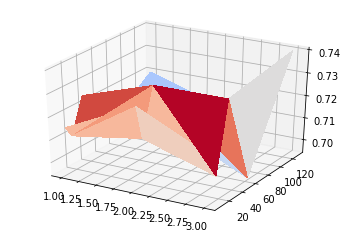

In [125]:
models=tune_ngram_model(data)

In [147]:
final_model = history[0]

In [148]:
history

(<tensorflow.python.keras.engine.sequential.Sequential at 0x207f28ae898>,
 0.73,
 0.5516327953338623)

In [157]:
x_train, x_val = vectorize_data.ngram_vectorize(
        training_set['lyrics'], training_set['mood'], validation_set['lyrics'])

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1567: UserWarning: Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. int32 'dtype' will be converted to np.float64.
  UserWarning)


In [158]:
training_set['predicted']=history[0].predict(x_train)
validation_set['predicted']=history[0].predict(x_val)

In [159]:
training_set['predicted_mood']=training_set['predicted'].apply(lambda x:'happy' if x>0.5 else 'sad')

In [160]:
validation_set['predicted_mood']=validation_set['predicted'].apply(lambda x:'happy' if x>0.5 else 'sad')

In [161]:
training_set['mood']=training_set['mood'].apply(lambda x:'happy' if x==1 else 'sad')

In [162]:
validation_set['mood']=validation_set['mood'].apply(lambda x:'happy' if x==1 else 'sad')

In [163]:
validation_set['mood'].head()

0    happy
1      sad
2    happy
3      sad
4      sad
Name: mood, dtype: object

In [164]:
training_set['mood'].head()

0      sad
1    happy
2      sad
3    happy
4      sad
Name: mood, dtype: object

In [165]:
from sklearn.metrics import confusion_matrix
train_cm = confusion_matrix(training_set['mood'], training_set['predicted_mood'],labels=['happy','sad'])
train_cm

array([[446,   0],
       [  3, 551]], dtype=int64)

In [166]:
from sklearn.metrics import confusion_matrix
test_cm = confusion_matrix(validation_set['mood'], validation_set['predicted_mood'],labels=['happy','sad'])
test_cm

array([[68, 37],
       [17, 78]], dtype=int64)

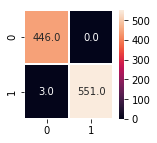

In [167]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
f,ax = plt.subplots(figsize=(2, 2))
sns.heatmap(train_cm, annot=True, linewidths=1, fmt= '.1f',ax=ax)
#plt.title('Confusion Matrix for train dataset')
#plt.show()


## <b> 0 = Happy and 1 = Sad </b>
## Legend : 
 <b> x axis = Predicted Values </b> <br>
 <b> y axis = Actual Values </b>

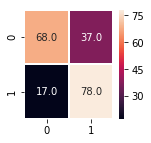

In [168]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
f,ax = plt.subplots(figsize=(2, 2))
sns.heatmap(test_cm, annot=True, linewidths=1, fmt= '.1f',ax=ax)
plt.show()


## <b> 0 = Happy and 1 = Sad </b>
## Legend : 
 <b> x axis = Predicted Values </b> <br>
 <b> y axis = Actual Values </b>

In [169]:
import numpy as np
from sklearn.metrics import accuracy_score
train_accuracy = accuracy_score(training_set['mood'], training_set['predicted_mood'])
train_accuracy

0.997

In [170]:
import numpy as np
from sklearn.metrics import accuracy_score
test_accuracy = accuracy_score(validation_set['mood'], validation_set['predicted_mood'])
test_accuracy

0.73

In [171]:
from sklearn.metrics import f1_score
train_f1_score = f1_score(training_set['mood'], training_set['predicted_mood'],pos_label='happy')
train_f1_score


0.9966480446927374

In [172]:
from sklearn.metrics import f1_score
test_f1_score = f1_score(validation_set['mood'], validation_set['predicted_mood'],pos_label='happy')
test_f1_score

0.7157894736842105

In [173]:
validation_set['predicted_mood'].value_counts()

sad      115
happy     85
Name: predicted_mood, dtype: int64

In [174]:
validation_set['mood'].value_counts()

happy    105
sad       95
Name: mood, dtype: int64

In [175]:
training_set

,file,artist,title,lyrics,genre,mood,year,predicted,predicted_mood
0,TRAAAAW128F429D538.h5,Casual,I Didn't Mean To,verse one alright i might have had a little gl...,Hip Hop/Rap,sad,1994,0.050266,sad
1,TRAAAEF128F4273421.h5,Adam Ant,Something Girls,adam ant marco pirroni every girl is a somethi...,Rock,happy,1982,0.850061,happy
2,TRAAAFD128F92F423A.h5,Gob,Face the Ashes,i ve just erased it s been a while i ve got a ...,Rock,sad,2007,0.033036,sad
3,TRAABJV128F1460C49.h5,Lionel Richie,Tonight Will Be Alright,little darling where you ve been so long i ve ...,R&B,happy,1986,0.973561,happy
4,TRAABLR128F423B7E3.h5,Blue Rodeo,Floating,lead vocal by greg well these late night conve...,Rock,sad,1987,0.080518,sad
5,TRAABVM128F92CA9DC.h5,Tesla,Caught In A Dream,if you can imagine this the whole world sharin...,Rock,happy,2004,0.919319,happy
6,TRAACER128F4290F96.h5,The Dillinger Escape Plan,Setting Fire to Sleeping Giants,first off let me say you look so tired rest yo...,Rock,happy,2004,0.896301,happy
7,TRAACFV128F935E50B.h5,SUE THOMPSON,James (Hold The Ladder Steady),james james hold the ladder steady james james...,Pop,happy,1985,0.867113,happy
8,TRAACHN128F1489601.h5,Five Bolt Main,Made Like This (Live),conclusions illusions of mainstream intrusions...,Rock,sad,2006,0.054243,sad
9,TRAACNS128F14A2DF5.h5,Willie Bobo,Spanish Grease,ain t no love ain t no love ain t no love ain ...,Jazz,sad,1997,0.065542,sad


In [176]:
#test and train roc
from sklearn.metrics import roc_curve,auc
test_fpr, test_tpr, test_thresholds = roc_curve(validation_set['mood'], validation_set['predicted'], pos_label='happy')
test_roc_auc = auc(test_fpr, test_tpr)

In [177]:
train_fpr, train_tpr, train_thresholds = roc_curve(training_set['mood'], training_set['predicted'], pos_label='happy')
train_roc_auc = auc(train_fpr, train_tpr)

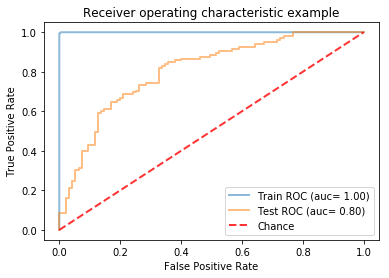

In [178]:
plt.plot(train_fpr, train_tpr, lw=2, alpha=0.5,
             label='Train ROC (auc= %0.2f)' % (train_roc_auc))
plt.plot(test_fpr, test_tpr, lw=2, alpha=0.5,
             label='Test ROC (auc= %0.2f)' % (test_roc_auc))
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

Final model

In [179]:
from tensorflow import keras
new_model = keras.models.load_model('song_mood_mlp_model.h5')
new_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_39 (Dropout)         (None, 10631)             0         
_________________________________________________________________
dense_39 (Dense)             (None, 64)                680448    
_________________________________________________________________
dropout_40 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_40 (Dense)             (None, 1)                 65        
Total params: 680,513
Trainable params: 680,513
Non-trainable params: 0
_________________________________________________________________


<table>
 <tr>
    
   <th>Model</th>
    <th>Test/Train</th>
   <th>Accuracy(%)</th>
   <th>F1 Score</th>
    <th>AUC Curve</th>
 </tr>
 <tr>
   <td>Multi layer perceptron</td>
   <td>Train</td>
   <td>99.7</td>
    <td>0.9966405375139977</td>
    <td>1</td>
 </tr>
 <tr>
   <td>Multi layer perceptron</td>
   <td>Test</td>
   <td>73</td>
    <td>0.7272727272727272</td>
    <td>0.81</td>
 </tr>
</table>

## Accuracy:
Accuracy is one metric for evaluating classification models. Informally, accuracy is the fraction of predictions our model got right.<br>
Our model is predicting 73% correctly.  

## F1 Score:
F1 score means that you have low false positives and low false negatives, so you're correctly identifying real threats and you are not disturbed by false alarms. An F1 score is considered perfect when it's 1 , while the model is a total failure when it's 0.<br>
Our F1 score is approximately 0.72

## Receiver Operating Characteristics:
An ROC curve (receiver operating characteristic curve) is a graph showing the performance of a classification model at all classification thresholds.<br>This curve plots two parameters:<br>
True Positive Rate<br>
False Positive Rate<br>
Our AUC is 0.81

In [ ]:
from tensorflow import keras
import vectorize_data
import pandas as pd
def predict_top_k_list(topklistdf):
  top_k_lyrics = topklistdf['lyrics']
  training_set = pd.read_csv('train_lyrics_1000.csv',encoding='UTF-8')
  training_set['mood'] = training_set['mood'].apply(lambda x:1 if x=='happy' else 0)
  x_train, x_top_k_list = vectorize_data.ngram_vectorize(training_set['lyrics'],training_set['mood'],top_k_lyrics)
  new_model = keras.models.load_model('song_mood_mlp_model.h5')
  predicted_mood=new_model.predict(x_top_k_list)
  topklistdf['predicted']= predicted_mood
  topklistdf['mood'] = topklistdf['predicted'].apply(lambda x: 'Happy' if x>=(0.50) else 'Sad')
  topklistdf['probability'] = topklistdf['predicted'].apply(lambda x: x*100 if x>=(0.50) else 100*(1-x))
  return topklistdf
  
  